# Análisis de viajes en taxi en Chicago

En este proyecto se analizará información sobre los viajes en taxi de varias compañías en Chicago, los principales barrios de destino y el impacto que tienen las condiciones atmosféricas en la duración de los viajes.

**Tabla de contenidos**<a id='toc0_'></a>    
- [Información general](#toc1_)    
- [Análisis exploratorio de datos](#toc2_)    
  - [Los 10 principales barrios de finalización de viajes](#toc2_1_)    
  - [Compañias con más viajes en promedio](#toc2_2_)    
- [Prueba de hipótesis](#toc3_)    
- [Conclusiones](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_'></a>[Información general](#toc0_)

In [26]:
# Librerías
from scipy import stats as st
from scipy.stats import levene
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 

In [27]:
# Primer dataset
company_trips = pd.read_csv('/datasets/project_sql_result_01.csv')
company_trips.head()

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


In [28]:
company_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


No existen valores nulos ni problemas con el tipo de datos en este dataset.

In [29]:
dropoff_data = pd.read_csv('/datasets/project_sql_result_04.csv')
dropoff_data.head()

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


In [30]:
dropoff_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


La información nuevamente luce correcta. Solo se reducirá el numero de decimales para más practicidad.

In [31]:
#Redondeo de la columna average_trips 
dropoff_data['average_trips'] = dropoff_data['average_trips'].round(decimals=2)
dropoff_data.head()

,dropoff_location_name,average_trips
0,Loop,10727.47
1,River North,9523.67
2,Streeterville,6664.67
3,West Loop,5163.67
4,O'Hare,2546.90


## <a id='toc2_'></a>[Análisis exploratorio de datos](#toc0_)

### <a id='toc2_1_'></a>[Los 10 principales barrios de finalización de viajes](#toc0_)

In [32]:
top10_neighborhoods = dropoff_data.sort_values(by='average_trips', ascending=False).head(10)
top10_neighborhoods

,dropoff_location_name,average_trips
0,Loop,10727.47
1,River North,9523.67
2,Streeterville,6664.67
3,West Loop,5163.67
4,O'Hare,2546.90
5,Lake View,2420.97
6,Grant Park,2068.53
7,Museum Campus,1510.00
8,Gold Coast,1364.23
9,Sheffield & DePaul,1259.77


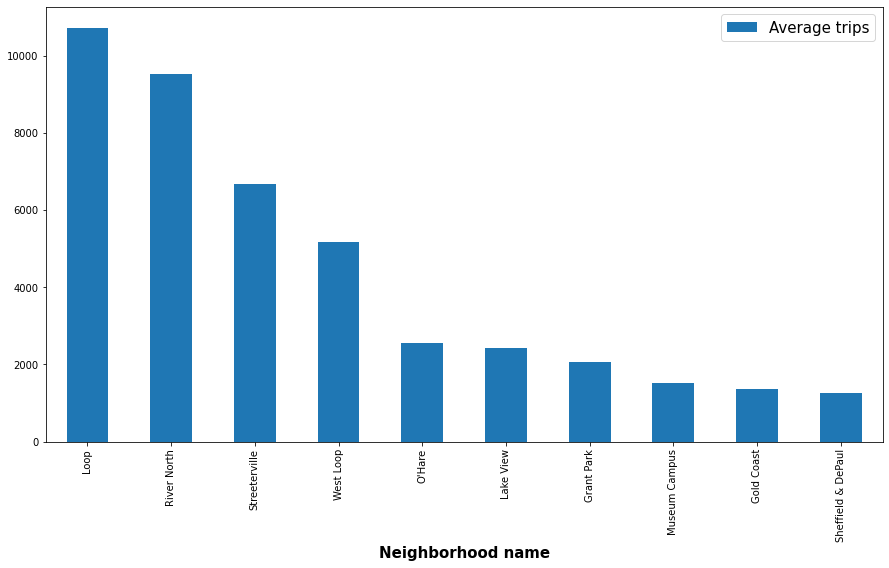

In [33]:
top10_neighborhoods.plot(x='dropoff_location_name', y='average_trips', kind='bar', figsize=(15,8))
plt.legend(['Average trips'], fontsize=15)
plt.xlabel('Neighborhood name', fontsize=15, fontweight='bold')
plt.show()

Los barrios donde más terminaron los viajes son Loop, con más de diez mil setecientos viajes en promedio, River North, con más de nueve mil quinientes, y, Streeterville, con más de seis mil seiscientos. 

### <a id='toc2_2_'></a>[Compañias con más viajes en promedio](#toc0_)

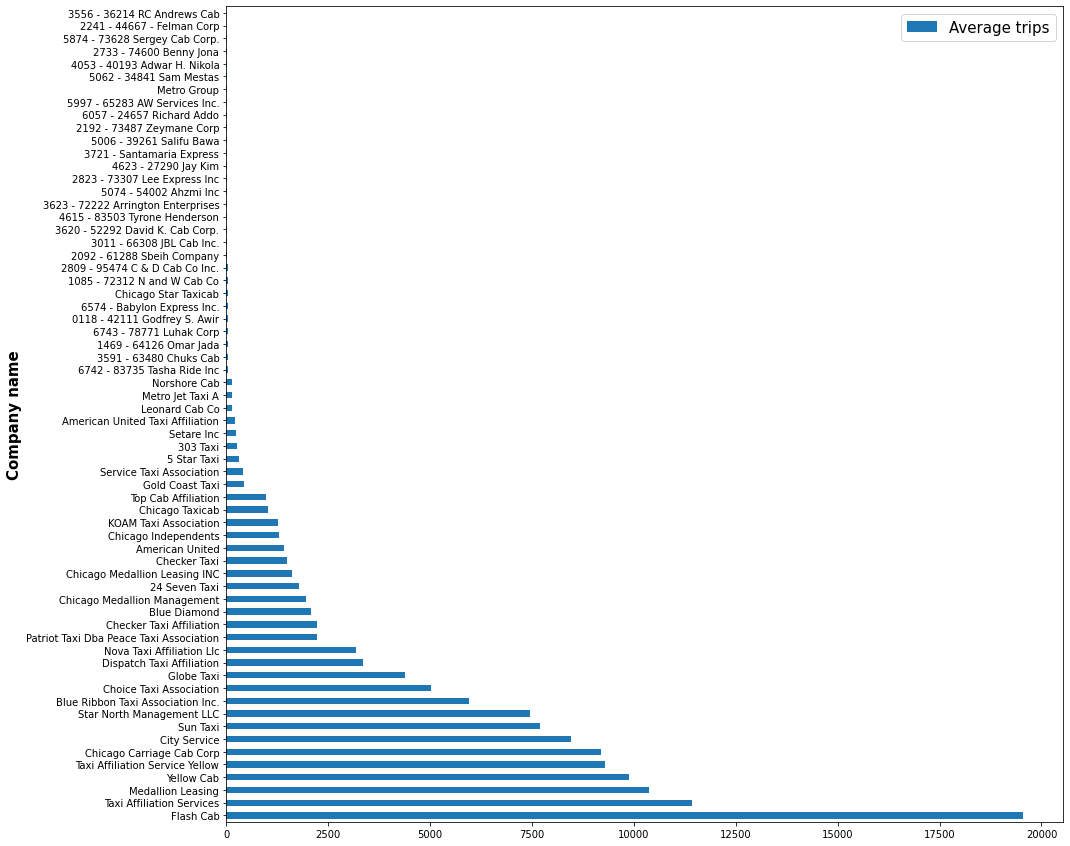

In [34]:
company_trips.plot.barh(x='company_name', y='trips_amount', rot=0, figsize=(15, 15))
plt.legend(['Average trips'], fontsize=15)
plt.ylabel('Company name', fontsize=15, fontweight='bold')
plt.show()

Flash cab lleva una importante diferencia con respecto al resto de compañias ya que acumula casi veinte mil viajes en promedio. Le siguen Tax Affiliation Services y Medallion Leasing que tienen entre novecientos y mil doscientos viajes.
Se observa también que a partir de Gold Coast Taxi las compañia acumulan menos de mil viajes cada una, lo cual podrían ser números significativamente bajos.

## <a id='toc3_'></a>[Prueba de hipótesis](#toc0_)

Se desea conocer si las duraciones de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare son diferentes en los días lluviosos a partir del siguiente dataset:

In [35]:
loop_to_ohare = pd.read_csv('/datasets/project_sql_result_07.csv')
loop_to_ohare.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


In [36]:
loop_to_ohare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


Se evalúan las siguientes hipótesis: 
- **Hipótesis nula:** La duración de los viajes son iguales en los días lluviosos y normales. 

- **Hipótesis alternativa:** La duración de los viajes en días lluviosos es distinta que en días normales.


In [37]:
# Se crean slices para cada grupo
good_weather = loop_to_ohare.query('weather_conditions == "Good"') 
bad_weather = loop_to_ohare.query('weather_conditions == "Bad"')

In [42]:
# Se muestra la varianza de calificaciones ambos grupos
print(f"Varianza de duración de viaje del grupo Good: {np.var(good_weather['duration_seconds'])}")
print(f"Varianza de duración de viaje del grupo Bad: {np.var(bad_weather['duration_seconds'])}")

# Se muestra la media de calificaciones de ambos grupos
print()
print(f"Media de duración de viaje del grupo Good: {good_weather['duration_seconds'].mean()}")
print(f"Media de duración de viaje del grupo Bad: {bad_weather['duration_seconds'].mean()}")

Varianza de duración de viaje del grupo Good: 575732.9308497686
Varianza de duración de viaje del grupo Bad: 517403.56330246915

Media de duración de viaje del grupo Good: 1999.6756756756756
Media de duración de viaje del grupo Bad: 2427.2055555555557


Primero se aplica el test de Levene para evaluar la igualdad de varianzas entre los grupos de datos. Se evalúa la hipótesis nula de que las varianzas son iguales en ambos grupos y la hipótesis alternativa de que las varianzas difieren.

In [39]:
# Prueba de igualdad de varianzas

alpha  = 0.05

result = levene(good_weather['duration_seconds'], bad_weather['duration_seconds'])


print('Valor p:', result.pvalue)

if result.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")


Valor p: 0.5332038671974493
No rechazamos la hipótesis nula


El valor p mayor al nivel de significancia (0.05) indica que las varianzas de ambos grupos son iguales. Por lo tanto, se establece `equal_var=True` en la prueba `scipy.stats.ttest_ind(array1, array2, equal_var)`.

In [40]:
# Prueba de hipótesis
alpha  = 0.05

results = st.ttest_ind(good_weather['duration_seconds'], bad_weather['duration_seconds'], equal_var=True)
print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")


p-value: 6.517970327099473e-12
Rechazamos la hipótesis nula


El resultado indica que existe evidencia estadística para rechazar la hipótesis nula dado el valor p significativamente menor a alpha. 
Es decir, se puede decir que las duración de los viajes en días lluviosos es distinta que en días normales.

## <a id='toc4_'></a>[Conclusiones](#toc0_)

En base a los resultados obtenidos, se puede concluir lo siguiente: 
1. Los barrios con la mayor cantidad promedio de viajes son Loop, River North y Streeterville. Estos barrios parecen ser destinos populares para los viajes.
2. Flash cab destaca significativamente en comparación con otras compañías, acumulando casi 20,000 viajes en promedio, una importante ventaja con respecto al resto de compañías.
3. La duración de los viajes entre el Loop y el Aeropuerto Internacional O'Hare en sábados cambia cuando el día es lluvioso. Por lo tanto, las condiciones atmosféricas juegan un rol en la duración de los viajes.